# Setup

In [2]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri

dl = DataLib("SignalData")

In [3]:
# Pull all the necessary dataframes to avoid duplicate code. 
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
CoreCPI = dl.pull("CoreCPI/SA")

# Sample Returns Stream
To speed up development, here we're going to make a two dummy signals. Our signal will be a time series of data telling us how long and how short to go in each bond market. Our long and short positions must be offsetting. We will use two dummy signals: 
- An equal weighting scheme (all long)
- A randomly weighted scheme using a Dirichlet distribution (equal long/short)

In [9]:
# Get the data (just use the year 2000 for simplicity).
bri = dl.pull("BondRetIdx/LocalFX")
index = bri.index
mask = (index >= '2000-1-1') & (index < '2001-1-1')
df = bri.loc[mask]

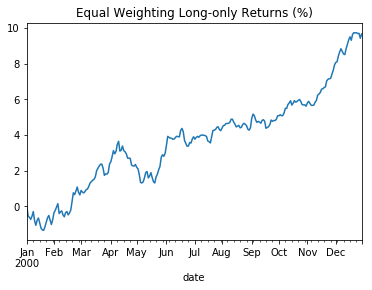

In [18]:
# Calculate our returns using an equal-weighted long-only scheme. 
abbr_ri = bri[mask]
abbr_returns = abbr_ri.pct_change()
equal_weight_returns = (0.1 * abbr_returns).sum(axis=1)
cumul_returns = ((equal_weight_returns + 1).cumprod() - 1) * 100
cumul_returns.plot(title='Equal Weighting Long-only Returns (%)')

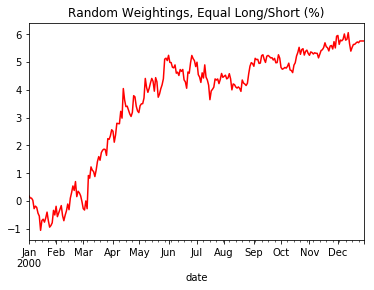

In [22]:
# Random signal with equal longs and shorts (every day).
signal = pd.DataFrame(df)
for ind in df.index: 
    signal.at[ind] = np.append(diri(np.ones(5),size=1), -1*diri(np.ones(5),size=1))

abbr_returns = abbr_returns.shift(-1)                # Shift returns back by one day. 
returns = (signal * abbr_returns).sum(axis=1)        # Calculate the returns. 
cumul_returns = ((returns + 1).cumprod() - 1) * 100  # Get cumulative returns. 

# Plot. 
cumul_returns.plot(title="Random Weightings, Equal Long/Short (%)", color='red')